# Selection of network depth and number of filters in convolutional layers

## Contents
* [Task description](#Task-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a model template](#Creating-a-model-template)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Task description
Select the architecture parameters of CNN, that classifies the MNIST data.

## The parameters studied
A number of building blocks with fixed layout i.e. network depth and a number of filters in convolutional layers.

## Parameters Value Area
A number of building blocks: [2, 3, 4, 5].

A number of filters in the first convolutional layer: [16, 32, 64].

## Metrics

Accuracy on the test set of the MNIST data.

## Dataset loading

For training and model performance assessment we use the MNIST dataset.

In [1]:
import sys
import os
sys.path.insert(0, os.path.join("..", ".."))

In [2]:
import glob
import dill

import numpy as np

from batchflow import Pipeline, B, V, C
from batchflow.opensets import MNIST
from batchflow.research import Option, Research, Results
from batchflow.models.tf import TFModel
from batchflow.models.tf.layers import conv_block

from src import get_accuracy, save_model, show_research

In [3]:
mnist_set = MNIST()

DownloadingDownloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz 
DownloadingExtracting /tmp/train-labels-idx1-ubyte.gz
 http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gzExtracting /tmp/train-images-idx3-ubyte.gz

Extracting /tmp/t10k-labels-idx1-ubyte.gz


## Dataset bypass:

- Define a root pipeline that will be shared between different models
- Define batch size and fix a dataset bypass order fixing the seed

In [4]:
BATCH_SIZE = 64

In [5]:
train_root = (Pipeline()
                .run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True, seed=123) << mnist_set.train)
              
test_root = (Pipeline()
                .run(BATCH_SIZE, shuffle=True, n_epochs=1, lazy=True, seed=123) << mnist_set.test)

## Creating a model template

We create a small CNN architecture passing layers' parameters to `model_config`.
The parameters that will vary are defined as `C('parameter_name')`.

We vary `n_blocks` and `n_filters` - an initial number of filters in the first convolutional layer.
In each subsequent convolutional layer number of filters is doubled.

Each block has a fixed configuration layout `layout='cpna'` that corresponds to a sequence of convolution, pooling, batch normalization and activation function.

In [6]:
NUM_CLASSES = 10

In [7]:
class ConvModel(TFModel):
    def body(cls, inputs, **kwargs):
        x = inputs
        for i in range(kwargs['n_blocks']):
            x = conv_block(x, 'cpna', filters=2 ** i * kwargs['n_filters'],
                           kernel_size=3, strides=2, pool_strides=1, name='block_' + str(i))
        return x

In [8]:
model_config = {
    'inputs': dict(images=dict(shape=B('image_shape')),
                   labels=dict(classes=NUM_CLASSES, transform='ohe', name='targets')),
    'body': dict(n_blocks=C('n_blocks'),
                 n_filters=C('n_filters')),
    'head': dict(layout='Pf', units=NUM_CLASSES),
    'initial_block/inputs': 'images',
    'loss': 'cross-entropy',
    'optimizer': 'Adam'}

Create training and test pipelines

In [9]:
train_template = (Pipeline()
                  .init_variable('loss', init_on_each_run=list)
                  .init_variable('accuracy', init_on_each_run=list)
                  .init_model('dynamic', ConvModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')},
                               save_to=V('loss'), mode='w'))

test_template = (Pipeline()
                 .import_model('mnist_model', C('import_from'))
                 .init_variable('loss', init_on_each_run=list)
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable('metrics', init_on_each_run=None)
                 .to_array()
                 .predict_model('mnist_model', fetches=['loss', 'predictions'],
                                feed_dict={'images': B('images'),
                                           'labels': B('labels')},
                                save_to=[V('loss'), V('predictions')])
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='logits', axis=-1, save_to=V('metrics'), mode='u'))

## Creating a research object

Set the parameters for `research` execution:

For each parameter set perform NUM_ITERS=400 iterations of train pipeline with model performance evaluation every 50 iterations. Repeat this procedure NUM_REPEAT=3 times.

We add to the `research` a function `get_accuracy` that gets results of the test pipeline and will be executed every 50 iterations.

In [10]:
op1 = Option('n_blocks', [2, 3, 4, 5])
op2 = Option('n_filters', [16, 32, 64])
grid = op1 * op2

research = (Research()
            .pipeline(root=train_root, branch=train_template, variables='loss', name='train')
            .pipeline(root=test_root, branch=test_template,  variables='loss', name='test', execute='%50',
                      run=True, import_from='train')
            .grid(grid)
            .function(get_accuracy, returns='accuracy', name='test_accuracy',
                  execute='%50', pipeline='test'))

In [11]:
NUM_REPEAT = 3
NUM_ITERS = 400
research_name = 'blocks_filters_research'

In [12]:
research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, progress_bar=True)

Research blocks_filters_research is starting...


  0%|          | 0/14400 [00:00<?, ?it/s]

Distributor has 36 jobs with 400 iterations. Totally: 14400


100%|██████████| 14400/14400 [30:03<00:00,  7.98it/s]


## Results:

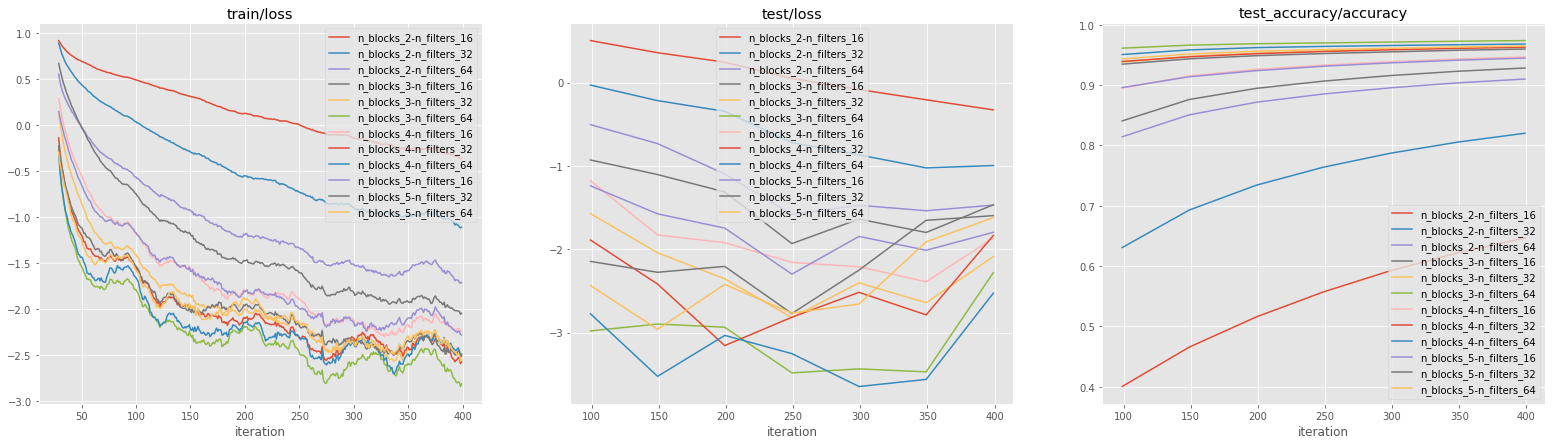

In [13]:
data = Results(path=research_name).load(use_alias=True)
show_research(data, average_repetitions=True, log_scale=[True, True, False],
              layout=['train/loss', 'test/loss', 'test_accuracy/accuracy'],
              rolling_window=[30, 2, 2])

## Conclusion

As we can see on the test accuracy graphic, the best model is the one with parameters n_blocks=3, n_filters=64

Despite the fact that the chosen configuration of the model was on average better than others, it is useful, along with a point estimate, to obtain the distribution of the metric over N independent runs of the training procedure.